# The Jacobian matrix and gradients of the objective function

The forward operator typically brings along the ability to compute the Jacobian matrix, i.e. the partial derivatives of the readings $r_i$ with respect to some model parameter $m_j$. This is also referred to as sensitivity matrix

$$ S_{ij} = \frac{\partial r_i}{\partial p_j} $$

These intrinsic readings could be measured travel times, voltages/resistances, or apparent resistivities.
The intrinsic parameter is typically something that defines the physical equations, like slowness or conductivity/resistivity.

However, in inversion we often do not use these quantities but a model parameter $m(p)$ and data $d(r)$.
Typically, the logarithm of the models is used to ensure positivity, e.g. $m=\log p$.
Data are also somtimes log-transformed, like decay curves, even including a possible sign.

Therefore the Jacobian matrix of the inverse problem is different and contains the inner derivatives:
$$ J_{ij} = \frac{\partial d_i}{\partial m_j} = S_{ij} * \frac{\partial d}{\partial r}(f_j(m)) / \frac{\partial m}{\partial p}(m_j) $$

$S$ is obtained from the forward operator by `fop.jacobian()`, whereas $J$ can be obtained by `inv.jacobianMatrix()`.
The latter takes the former and multiplies it with the partial derivatives.

In [93]:
import numpy as np
import pygimli as pg
from pygimli.math.matrix import matrixRow
from pygimli.physics import ert

In [94]:
def exactLineSearch(inv, taus=None, show=False):
    """Line search by exact forward response."""
    taus = np.logspace(-2, 0, 21)
    phis = np.zeros_like(taus)
    for i, tau in enumerate(taus):
        newModel = inv.modelTrans.update(inv.model, inv.gradient()*tau)
        newResponse = inv.fop.response(newModel)
        phis[i] = inv.inv.getPhi(newModel, newResponse)

    if show:
        pg.plt.semilogx(taus, phis)

    return taus[np.argmin(phis)], min(phis)

Let us exemplify this by a simple ERT case: We load the data and start inversion with a homogeneous half-space.

In [95]:
data = pg.getExampleData("ERT/gallery.dat")
data.estimateError()
print(data)
mgr = ert.Manager(data)
mgr.invert(paraDX=0.25, quality=34.3, maxIter=0, verbose=True)
inv = mgr.inv  # for brevity and generality

26/07/24 - 09:08:23 - pyGIMLi - INFO - Looking for ERT/gallery.dat in gimli-org/example-data/
26/07/24 - 09:08:24 - pyGIMLi - INFO - Cache c:\Guenther.T\src\gimli\gimli\pygimli\physics\ert\ert.py:createGeometricFactors restored (0.0s x 67): C:\Guenther.T\Anwendungsdaten\pygimli\Cache\13633420947223655174
26/07/24 - 09:08:24 - pyGIMLi - INFO - Found 2 regions.
26/07/24 - 09:08:24 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
26/07/24 - 09:08:24 - pyGIMLi - INFO - Found 2 regions.
26/07/24 - 09:08:24 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
26/07/24 - 09:08:24 - pyGIMLi - INFO - Creating forward mesh from region infos.
26/07/24 - 09:08:24 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
26/07/24 - 09:08:24 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 2004 Cells: 3772 Boundaries: 2946
26/07/24 - 09:08:24 - pyGIMLi - INFO - Use median(data values)=204.445
26/07/24 - 09:08:24 - p

26/07/24 - 09:08:24 - pyGIMLi - INFO - Starting inversion.


Data: Sensors: 21 data: 116, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']
fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x00000195305DC720>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x00000195305DC0E0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x00000195305DCAE0>
min/max (data): 84.65/367
min/max (error): 3%/3%
min/max (start model): 204/204
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =  135.28


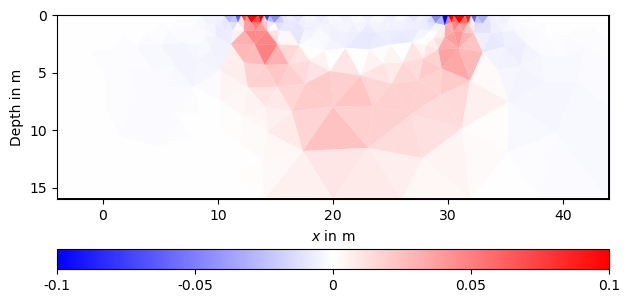

In [96]:
jac = inv.jacobianMatrix()
row = matrixRow(jac, 111)
pg.show(mgr.paraDomain, row, cMin=-0.1, cMax=0.1, cMap="bwr");

By default, the matrix is a pyGIMLi matrix (here a left and right scaled version of a dense matrix).
But one can also retrieve it is numpy matrix (copying!) for easier treatment.

In [97]:
J = inv.jacobianMatrix(error_weighted=True, numpy_matrix=True)
print(J.shape)

(116, 507)


The residual $\delta d$ is the error-weighted difference between data and model response, taking the data transform into account.
Note that not only the two vectors, but also the errors need to be transformed by the function `dT.error()`.

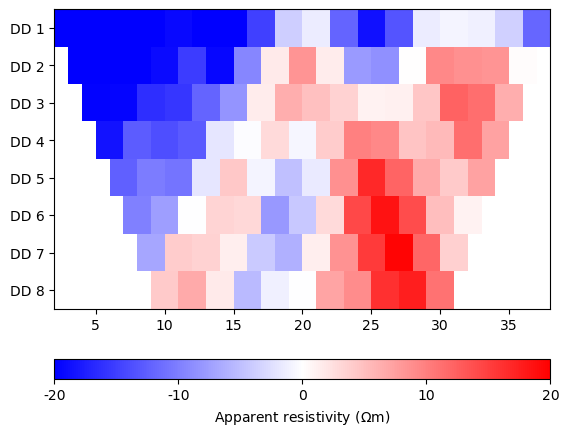

In [98]:
dT = inv.dataTrans
residual = (dT(inv.dataVals) - dT(inv.response)) / dT.error(inv.response, inv.errorVals)  # by hand
residual = inv.residual()  # simple function
pg.show(data, residual, cMin=-20, cMax=20, cMap="bwr");

The (data) gradient of the objective function can be computed by $J^T \delta d$.
This can also be done by the function `inv.dataGradient()`.

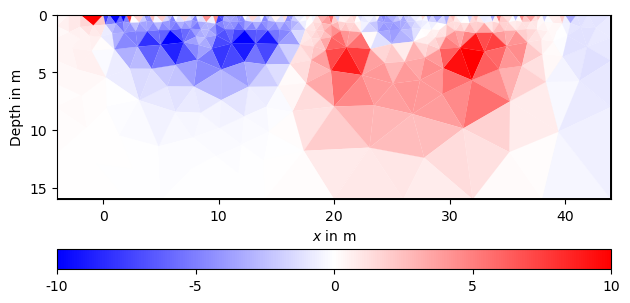

In [99]:
gradient = jac.transMult(residual)
# gradient = inv.dataGradient() # the same, also inv.gradient()
pg.show(mgr.paraDomain, gradient, cMin=-10, cMax=10, cMap="bwr");

Obviously the model needs increasement in the right part and decreasement in the left part.
For updating the model, the function `tM.update(model, deltaModel)` is used.
Without optimizing the line search parameter (step length), we set it to some arbitrary value.

26/07/24 - 09:08:28 - pyGIMLi - INFO - 1.0


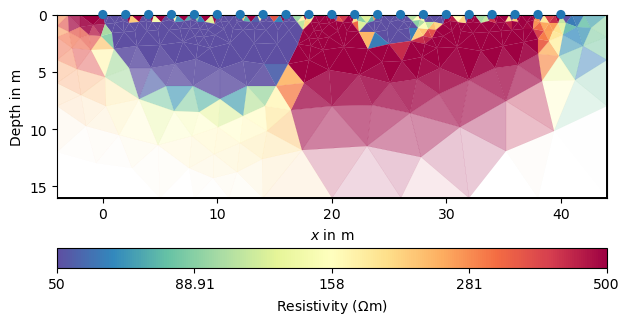

In [100]:
tau, response = exactLineSearch(inv)
pg.info(tau)
newModel = inv.modelTrans.update(inv.model, gradient*tau) # pg.exp(gradient*0.1)*mgr.model
mgr.showResult(newModel, cMin=50, cMax=500);

To continue inversion with this updated model, we have to set the model, but also its forward response and recompute the Jacobian.

In [101]:
mgr.inv.model = newModel
mgr.inv.response = mgr.fop(newModel)
mgr.fop.createJacobian(newModel)

The model now shows some structure but is rather smooth.
We do the same, one iteration, but with the default Gauss-Newton method.

In [102]:
# mgr = ert.Manager(data)
# mgr.invert(maxIter=1, verbose=True)
# mgr.showResult(cMin=50, cMax=500);

The model is much less smooth and already contains the main features of the final model with a data fit approaching the target value of 1.
This underlines the strength of the minimization method.

We now again look at the data gradient.

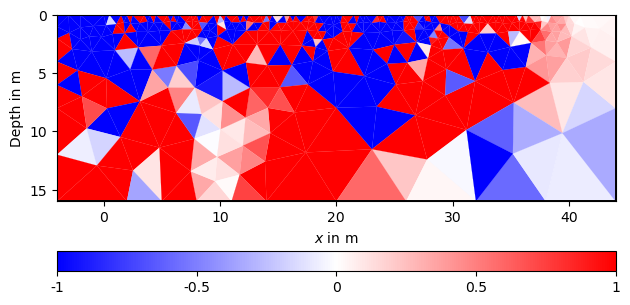

In [103]:
inv = mgr.inv
pg.show(mgr.paraDomain, inv.dataGradient(), cMin=-10, cMax=10, cMap="bwr");

This is much weaker and smoother now. 
Additionally, we look at the model gradient, i.e. how the model wants to go back to the homogeneous model.
We weight this with the regularization parameter to have the same color scale.

In [104]:
# logModel = inv.modelTrans(inv.model)
# pg.show(mgr.paraDomain, logModel, logScale=False)

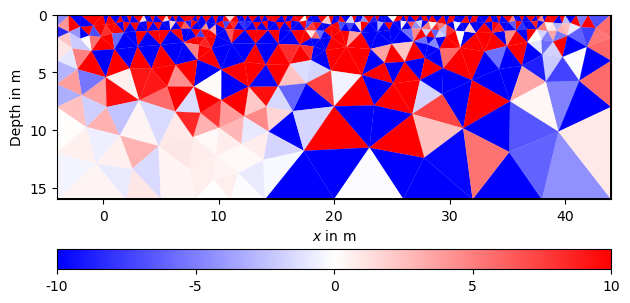

In [105]:
pg.show(mgr.paraDomain, inv.modelGradient()*inv.lam, cMin=-10, cMax=10, cMap="bwr");

This is basically the inverse structure of the model.
If we combine both gradients, we have the next model update direction.

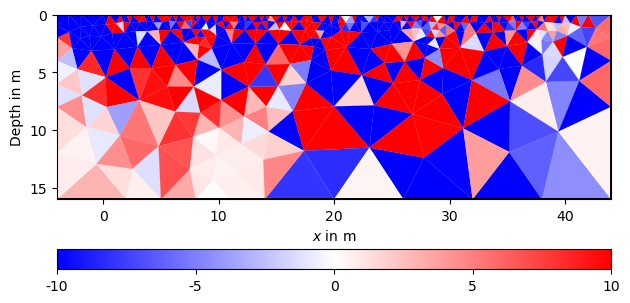

In [106]:
pg.show(mgr.paraDomain, inv.gradient(), cMin=-10, cMax=10, cMap="bwr");

In [109]:
tau, response = exactLineSearch(inv)
pg.info(tau)
newModel = inv.modelTrans.update(mgr.inv.model, inv.gradient()*tau)
mgr.showResult(newModel, cMin=50, cMax=500);

RuntimeError: !!! Critical !!!:  response for model with negative or zero resistivity is not defined.: 0 inf

In [108]:
tau, response = exactLineSearch(inv)
print(tau)

RuntimeError: !!! Critical !!!:  response for model with negative or zero resistivity is not defined.: 0 inf